### Winning the game

As Herm Edwards infamously said, "You play to win the game!". So that's where we'll start. We will try to identify how likely each team is to win. The cool thing is that we are going to do this during the game itself - so as players get hits, or outs, or whatever else, we will see how their team's chance of winning changes.

We're gonna do a few things here. First we'll collect information known before the start of the game - how has each team been performing, what are the game conditions, etc.  Then, we'll layer in details about the game state - whats the score, who's on base, and how many outs there are. Combine the two, and you can get a good prediction of who will win, and what the final score will be, at any given time. 

In [1]:
import os
import sys
import numpy as np
import pandas as pd
import pickle
from sqlalchemy import create_engine

import keras
from keras.layers import Input, Dense, Concatenate, Add
from keras.layers.noise import AlphaDropout
from keras.models import Model
from keras.callbacks import EarlyStopping

import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from joblib import dump, load

from plotnine import *
from credentials import BASEBALL_DB_NAME, BASEBALL_DB_PWD

%matplotlib inline

engine = create_engine('postgresql://baseball:{}@localhost:5432/{}'.format(BASEBALL_DB_PWD, BASEBALL_DB_NAME))

res = engine.execute("""DROP TABLE IF EXISTS game_data_long;
                     CREATE TABLE game_data_long AS
                     (SELECT game_id, date, day_of_week, day_night, temperature, 'home' AS home_visitor
                     , home AS team, hom_pitcher AS pitcher, hom_score AS score, hom_hits AS hits
                     , visitor AS opp_team, vis_pitcher AS opp_pitcher, vis_score AS opp_score
                     , vis_hits AS opp_hits, CASE WHEN hom_score > vis_score THEN 1 ELSE 0 END AS win_flag 
                     FROM game_data)
                     
                     UNION 
                     
                     (SELECT game_id, date, day_of_week, day_night, temperature, 'visitor' AS home_visitor
                     , visitor AS team, vis_pitcher AS pitcher, vis_score AS score, vis_hits AS hits
                     , home AS opp_team, hom_pitcher AS opp_pitcher, hom_score AS opp_score
                     , hom_hits AS opp_hits, CASE WHEN vis_score > hom_score THEN 1 ELSE 0 END AS win_flag 
                     FROM game_data);""")

res.close()

In [2]:
res = engine.execute("""
DROP TABLE IF EXISTS team_win_data;
CREATE TABLE team_win_data AS (
SELECT date, team

, AVG(win_flag) OVER (PARTITION BY team ORDER BY date ASC ROWS BETWEEN 11 PRECEDING AND 1 PRECEDING) AS win_pct_l10
, AVG(win_flag) OVER (PARTITION BY team ORDER BY date ASC ROWS BETWEEN 26 PRECEDING AND 1 PRECEDING) AS win_pct_l25
, AVG(win_flag) OVER (PARTITION BY team ORDER BY date ASC ROWS BETWEEN 51 PRECEDING AND 1 PRECEDING) AS win_pct_l50
, AVG(win_flag) OVER (PARTITION BY team ORDER BY date ASC ROWS BETWEEN 101 PRECEDING AND 1 PRECEDING) AS win_pct_l100

, AVG(score) OVER (PARTITION BY team ORDER BY date ASC ROWS BETWEEN 11 PRECEDING AND 1 PRECEDING) AS score_l10
, AVG(score) OVER (PARTITION BY team ORDER BY date ASC ROWS BETWEEN 26 PRECEDING AND 1 PRECEDING) AS score_l25
, AVG(score) OVER (PARTITION BY team ORDER BY date ASC ROWS BETWEEN 51 PRECEDING AND 1 PRECEDING) AS score_l50
, AVG(score) OVER (PARTITION BY team ORDER BY date ASC ROWS BETWEEN 101 PRECEDING AND 1 PRECEDING) AS score_l100

, AVG(opp_score) OVER (PARTITION BY team ORDER BY date ASC ROWS BETWEEN 11 PRECEDING AND 1 PRECEDING) AS opp_score_l10
, AVG(opp_score) OVER (PARTITION BY team ORDER BY date ASC ROWS BETWEEN 26 PRECEDING AND 1 PRECEDING) AS opp_score_l25
, AVG(opp_score) OVER (PARTITION BY team ORDER BY date ASC ROWS BETWEEN 51 PRECEDING AND 1 PRECEDING) AS opp_score_l50
, AVG(opp_score) OVER (PARTITION BY team ORDER BY date ASC ROWS BETWEEN 101 PRECEDING AND 1 PRECEDING) AS opp_score_l100

FROM game_data_long)
""")

res.close()

In [3]:
game_level_data = pd.read_sql("""SELECT g.*, 
h.win_pct_l10 AS home_win_pct_l10,
h.win_pct_l25  AS home_win_pct_l25,
h.win_pct_l50 AS home_win_pct_l50,
h.win_pct_l100 AS home_win_pct_l100,
h.score_l10 AS home_score_l10,
h.score_l25 AS home_score_l25,
h.score_l50 AS home_score_l50,
h.score_l100 AS home_score_l100,
h.opp_score_l10 AS home_opp_score_l10,
h.opp_score_l25 AS home_opp_score_l25,
h.opp_score_l50 AS home_opp_score_l50,
h.opp_score_l100 AS home_opp_score_l100,
POWER(h.score_l10, 2) / (POWER(h.score_l10, 2) + POWER(h.opp_score_l10, 2)) AS home_win_exp_l10,
POWER(h.score_l25, 2) / (POWER(h.score_l25, 2) + POWER(h.opp_score_l25, 2)) AS home_win_exp_l25,
POWER(h.score_l50, 2) / (POWER(h.score_l50, 2) + POWER(h.opp_score_l50, 2)) AS home_win_exp_l50,
POWER(h.score_l100, 2) / (POWER(h.score_l100, 2) + POWER(h.opp_score_l100, 2)) AS home_win_exp_l100,

v.win_pct_l10 AS visitor_win_pct_l10,
v.win_pct_l25  AS visitor_win_pct_l25,
v.win_pct_l50 AS visitor_win_pct_l50,
v.win_pct_l100 AS visitor_win_pct_l100,
v.score_l10 AS visitor_score_l10,
v.score_l25 AS visitor_score_l25,
v.score_l50 AS visitor_score_l50,
v.score_l100 AS visitor_score_l100,
v.opp_score_l10 AS visitor_opp_score_l10,
v.opp_score_l25 AS visitor_opp_score_l25,
v.opp_score_l50 AS visitor_opp_score_l50,
v.opp_score_l100 AS visitor_opp_score_l100,

POWER(v.score_l10, 2) / (POWER(v.score_l10, 2) + POWER(v.opp_score_l10, 2)) AS visitor_win_exp_l10,
POWER(v.score_l25, 2) / (POWER(v.score_l25, 2) + POWER(v.opp_score_l25, 2)) AS visitor_win_exp_l25,
POWER(v.score_l50, 2) / (POWER(v.score_l50, 2) + POWER(v.opp_score_l50, 2)) AS visitor_win_exp_l50,
POWER(v.score_l100, 2) / (POWER(v.score_l100, 2) + POWER(v.opp_score_l100, 2)) AS visitor_win_exp_l100

FROM game_data g 
INNER JOIN team_win_data h ON g.date = h.date AND g.home = h.team
INNER JOIN team_win_data v ON g.date = v.date AND g.visitor = v.team LIMIT 100;""", engine)

In [4]:
query = """
SELECT e.game_id, SUBSTRING(e.game_id, 4, 4) AS season, SUBSTRING(e.game_id, 4, 8) AS date
, g.visitor, g.home, CASE WHEN day_night = 'N' THEN 1 ELSE 0 END AS night_game
, game_site, inning, batting_team, outs, e.vis_score,e.hom_score
, batter, pitcher, event_num
, CASE WHEN runner_1b IS NOT NULL THEN 1 ELSE 0 END AS runner_1b 
, CASE WHEN runner_2b IS NOT NULL THEN 1 ELSE 0 END AS runner_2b 
, CASE WHEN runner_3b IS NOT NULL THEN 1 ELSE 0 END AS runner_3b 
, CASE WHEN g.hom_score > g.vis_score THEN 1 ELSE 0 END AS home_wins
, g.hom_score AS final_home_score
, g.vis_score AS final_vis_score
, g.hom_score + g.vis_score AS final_score

, w.vis_wins_season
, w.vis_losses_season
, w.hom_wins_season
, w.hom_losses_season

, w.vis_wins_100
, w.vis_losses_100
, w.hom_wins_100
, w.hom_losses_100

, w.vis_own_score_season
, w.vis_opp_score_season
, w.vis_own_score_100
, w.vis_opp_score_100

, w.hom_own_score_season
, w.hom_opp_score_season
, w.hom_own_score_100
, w.hom_opp_score_100


FROM event_data e

INNER JOIN game_data g ON e.game_id = g.game_id
INNER JOIN win_loss_data w ON e.game_id = w.game_id
""" 

event_data = pd.read_sql(query, engine)

In [5]:
from sklearn.preprocessing import StandardScaler

event_data['game_progress'] = ((event_data['inning'] - 1) * 6) + (event_data['batting_team'] * 3) + event_data['outs']
event_data['is_overtime'] = (event_data['game_progress'] >= 54) * 1.0
event_data['game_progress'] = np.minimum(event_data['game_progress'], 53)
event_data['date'] = pd.to_datetime(event_data['date'], format = '%Y%m%d')
event_data['day_of_week'] = event_data['date'].apply(lambda x: x.weekday())
event_data['month'] = event_data['date'].apply(lambda x: x.month)



In [6]:
event_data.head()

,game_id,season,date,visitor,home,night_game,game_site,inning,batting_team,outs,...,vis_own_score_100,vis_opp_score_100,hom_own_score_season,hom_opp_score_season,hom_own_score_100,hom_opp_score_100,game_progress,is_overtime,day_of_week,month
0,ANA201204060,2012,2012-04-06,KCA,ANA,1,ANA01,1,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,4,4
1,ANA201204060,2012,2012-04-06,KCA,ANA,1,ANA01,1,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,1,0.0,4,4
2,ANA201204060,2012,2012-04-06,KCA,ANA,1,ANA01,1,0,2,...,0.0,0.0,0.0,0.0,0.0,0.0,2,0.0,4,4
3,ANA201204060,2012,2012-04-06,KCA,ANA,1,ANA01,1,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,3,0.0,4,4
4,ANA201204060,2012,2012-04-06,KCA,ANA,1,ANA01,1,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,4,0.0,4,4


In [7]:
train_data = event_data.query("season in ['2015', '2016', '2017']").copy()
val_data = event_data.query("season in ['2018']").copy()
test_data = event_data.query("season == '2019'").copy()


In [8]:
train_game = train_data[['vis_wins_season', 'vis_losses_season', 'hom_wins_season', 'hom_losses_season'
                         , 'vis_wins_100', 'vis_losses_100', 'hom_wins_100', 'hom_losses_100'
                         , 'night_game', 'day_of_week', 'month', 'season']]
train_play = train_data[['batting_team', 'inning', 'outs', 'vis_score', 'hom_score', 'runner_1b', 'runner_2b', 'runner_3b'
                         , 'game_progress', 'is_overtime']]
train_target = train_data[['home_wins']].values.astype('int16')

val_game = val_data[['vis_wins_season', 'vis_losses_season', 'hom_wins_season', 'hom_losses_season'
                         , 'vis_wins_100', 'vis_losses_100', 'hom_wins_100', 'hom_losses_100'
                         , 'night_game', 'day_of_week', 'month', 'season']]
val_play = val_data[['batting_team', 'inning', 'outs', 'vis_score', 'hom_score', 'runner_1b', 'runner_2b', 'runner_3b'
                         , 'game_progress', 'is_overtime']]
val_target = val_data[['home_wins']].values.astype('int16')

test_game = test_data[['vis_wins_season', 'vis_losses_season', 'hom_wins_season', 'hom_losses_season'
                         , 'vis_wins_100', 'vis_losses_100', 'hom_wins_100', 'hom_losses_100'
                         , 'night_game', 'day_of_week', 'month', 'season']]
test_play = test_data[['batting_team', 'inning', 'outs', 'vis_score', 'hom_score', 'runner_1b', 'runner_2b', 'runner_3b'
                         , 'game_progress', 'is_overtime']]
test_target = test_data[['home_wins']].values.astype('int16')

In [9]:
#ohe = OneHotEncoder(handle_unknown='ignore', sparse = False)
#train_feature = ohe.fit_transform(train_feature)
#test_feature = ohe.transform(test_feature)

scale = StandardScaler()
train_game = scale.fit_transform(train_game).astype('float32')
val_game = scale.transform(val_game).astype('float32')
test_game = scale.transform(test_game).astype('float32')

dump(scale, 'std_scaler_game.bin', compress=True)


scale_play = StandardScaler()
train_play = scale_play.fit_transform(train_play).astype('float32')
val_play = scale_play.transform(val_play).astype('float32')
test_play = scale_play.transform(test_play).astype('float32')

dump(scale_play, 'std_scaler_play.bin', compress=True)

['std_scaler_play.bin']

In [10]:
train_game

array([[-1.4554611, -1.6585258, -1.5766445, ...,  1.4129812, -1.5087373,
        -1.2285401],
       [-1.4554611, -1.6585258, -1.5766445, ...,  1.4129812, -1.5087373,
        -1.2285401],
       [-1.4554611, -1.6585258, -1.5766445, ...,  1.4129812, -1.5087373,
        -1.2285401],
       ...,
       [ 1.3909414,  1.9315587,  2.3494964, ...,  1.4129812,  1.9641613,
         1.2216547],
       [ 1.3909414,  1.9315587,  2.3494964, ...,  1.4129812,  1.9641613,
         1.2216547],
       [ 1.3909414,  1.9315587,  2.3494964, ...,  1.4129812,  1.9641613,
         1.2216547]], dtype=float32)

# Win Probability by Event

Right now, we have data on each at bat in each game. These can be thought of as distinct *states*, and each has some probability of resulting in a win. A several run deficit in the bottom of the 9th is unlikely to end up as a win for the batting team. A tie game with 3 runners on is highly likely to end in a win for the batting team.

By converting each of these game states into a likelihood of victory, we can quantify how much each *at bat* improved or hurt the chances of a team winning. This is how we will conceptualize the value of different batters and pitchers.

Since we're building a neural net, we can get creative with the objective. In this case, we'll use all of the inputs to produce estimates of the final score for both teams. Then, we'll use the hidden state and these score estimates to produce an estimate of who will win. Training them together has a couple potential benefits: in particular, we have only one model to keep track of, and we're more likely to consider the outputs "consistent". It can damage trust if we estimate the home team would score more runs, but give them a low probability of winning!

We'll also exploit one more rule in baseball - there is no concept of a negative score. If a team has already scored 2 runs, it is impossible for them to score fewer than 2 runs in the end. To bake this in, we'll take the current score as an input, and model only an additive part - so the final score is the current score, plus some non-negative component.

To train it, we'll use two different losses. We'll use MSE to estimate the expected runs scored, and cross-entropy loss to get win probabilities out.

In [11]:
from tensorflow import keras
from tensorflow.keras.regularizers import l1
from tensorflow.keras.layers import Dropout
from tensorflow.keras.optimizers import Adam, Adadelta, RMSprop
from tensorflow.keras.callbacks import EarlyStopping

game_input = Input(shape=(train_game.shape[1], ))

d = Dense(4, activation='relu', kernel_initializer='lecun_normal')(game_input)
#d = Dropout(0.2)(d)
#d = Dense(8, activation='relu', kernel_initializer='lecun_normal')(d)

win_prediction = Dense(1, activation = 'sigmoid', name = 'win_predictions')(d)



play_input = Input(shape=(train_play.shape[1], ))
p = Dense(64, activation='relu', kernel_initializer='lecun_normal')(play_input)
p = Dropout(rate = 0.2)(p)
p = Dense(64, activation='relu', kernel_initializer='lecun_normal')(p)

play_prediction = Dense(1, activation = 'sigmoid', name = 'play_predictions')(p)
predictions = Concatenate()([win_prediction, play_prediction])

final_prediction = Dense(1, activation = 'sigmoid', name = 'final_predictions')(predictions)
#d = AlphaDropout(rate = 0.2)(d)
#d = Dense(64, activation='selu', kernel_initializer='lecun_normal')(d)
#d = AlphaDropout(rate = 0.2)(d)
#d = Dense(16, activation='selu', kernel_initializer='lecun_normal')(d)
#d = AlphaDropout(rate = 0.5)(d)

#d = Dense(64, activation='relu')(d)
#d = Dropout(rate = 0.5)(d)
#d = Dense(32, activation = 'selu')(d)


model = Model(inputs=[game_input, play_input], outputs=[win_prediction, play_prediction, final_prediction])
model.compile(optimizer=RMSprop(lr = 5e-4), loss='binary_crossentropy')
model.fit([train_game, train_play], [train_target, train_target, train_target]
          , batch_size = 128, epochs=100
          , validation_data=([val_game, val_play], [val_target, val_target, val_target])
          , callbacks = [EarlyStopping(patience = 10)])


Epoch 1/100
4465/4465 [==============================] - 12s 2ms/step - loss: 1.8638 - win_predictions_loss: 0.6890 - play_predictions_loss: 0.4823 - final_predictions_loss: 0.6925 - val_loss: 1.7621 - val_win_predictions_loss: 0.6817 - val_play_predictions_loss: 0.4730 - val_final_predictions_loss: 0.6074
Epoch 2/100
4465/4465 [==============================] - 10s 2ms/step - loss: 1.7081 - win_predictions_loss: 0.6858 - play_predictions_loss: 0.4719 - final_predictions_loss: 0.5505 - val_loss: 1.6697 - val_win_predictions_loss: 0.6827 - val_play_predictions_loss: 0.4719 - val_final_predictions_loss: 0.5151
Epoch 3/100
4465/4465 [==============================] - 11s 2ms/step - loss: 1.6500 - win_predictions_loss: 0.6854 - play_predictions_loss: 0.4693 - final_predictions_loss: 0.4953 - val_loss: 1.6443 - val_win_predictions_loss: 0.6836 - val_play_predictions_loss: 0.4716 - val_final_predictions_loss: 0.4890
Epoch 4/100
4465/4465 [==============================] - 11s 3ms/step - loss

4465/4465 [==============================] - 11s 3ms/step - loss: 1.6179 - win_predictions_loss: 0.6838 - play_predictions_loss: 0.4668 - final_predictions_loss: 0.4674 - val_loss: 1.6287 - val_win_predictions_loss: 0.6827 - val_play_predictions_loss: 0.4750 - val_final_predictions_loss: 0.4710
Epoch 28/100
4465/4465 [==============================] - 11s 3ms/step - loss: 1.6178 - win_predictions_loss: 0.6837 - play_predictions_loss: 0.4668 - final_predictions_loss: 0.4672 - val_loss: 1.6275 - val_win_predictions_loss: 0.6823 - val_play_predictions_loss: 0.4740 - val_final_predictions_loss: 0.4713
Epoch 29/100
4465/4465 [==============================] - 11s 2ms/step - loss: 1.6180 - win_predictions_loss: 0.6838 - play_predictions_loss: 0.4669 - final_predictions_loss: 0.4673 - val_loss: 1.6279 - val_win_predictions_loss: 0.6820 - val_play_predictions_loss: 0.4748 - val_final_predictions_loss: 0.4710
Epoch 30/100
4465/4465 [==============================] - 11s 3ms/step - loss: 1.6178 

4465/4465 [==============================] - 11s 3ms/step - loss: 1.6166 - win_predictions_loss: 0.6836 - play_predictions_loss: 0.4668 - final_predictions_loss: 0.4662 - val_loss: 1.6328 - val_win_predictions_loss: 0.6857 - val_play_predictions_loss: 0.4749 - val_final_predictions_loss: 0.4722
Epoch 54/100
4465/4465 [==============================] - 11s 3ms/step - loss: 1.6170 - win_predictions_loss: 0.6836 - play_predictions_loss: 0.4671 - final_predictions_loss: 0.4662 - val_loss: 1.6277 - val_win_predictions_loss: 0.6830 - val_play_predictions_loss: 0.4744 - val_final_predictions_loss: 0.4703
Epoch 55/100
4465/4465 [==============================] - 11s 2ms/step - loss: 1.6167 - win_predictions_loss: 0.6836 - play_predictions_loss: 0.4670 - final_predictions_loss: 0.4661 - val_loss: 1.6280 - val_win_predictions_loss: 0.6843 - val_play_predictions_loss: 0.4736 - val_final_predictions_loss: 0.4701
Epoch 56/100
4465/4465 [==============================] - 11s 3ms/step - loss: 1.6171 

In [20]:
from sklearn.metrics import log_loss

train_preds = model.predict([train_game, train_play])
#test_data['home_score_prediction'], test_data['vis_score_prediction'], test_data['home_win_prediction'] = test_preds[0][:, 0], test_preds[0][:, 1], test_preds[1]
train_data['home_win_prediction_start'] = train_preds[0]
train_data['home_win_prediction_final'] = train_preds[2]

test_preds = model.predict([test_game, test_play])
#test_data['home_score_prediction'], test_data['vis_score_prediction'], test_data['home_win_prediction'] = test_preds[0][:, 0], test_preds[0][:, 1], test_preds[1]
test_data['home_win_prediction_start'] = test_preds[0]
test_data['home_win_prediction_final'] = test_preds[2]

6001/6001 [==============================] - 7s 1ms/step


In [13]:
game_start = test_data.query('event_num == 1')
log_loss(y_pred=game_start['home_win_prediction_start'], y_true=game_start['home_wins'])

0.6792463662694049

In [14]:
model.save('win_prediction_model.h5')

In [15]:
test_data['predicted_win'] = test_data['home_win_prediction_final'] > 0.5

Let's do a quick sanity check - we'll split by whether or not the home team is predicted to win, and check how often the home team actually wins the game. On this metric, we want to see that the blue line is consistently higher than the red line - that is, in games where we predict the home team wins, they should actually win more than 50% of the time. We also expect that as the game progresses, the two will diverge more as we are more and more confident of which team will win.

For the first few events, the model is more or less guessing. Both lines are near 50%, so our predictions aren't strongly correlated with the outcome yet. There's a little seperation there, but not much. This isn't surprising - we've given it little information, and there is a lot of time for the outcome to change! 

By event 40 or so, however, the model is much more confident and accurate in its predictions. The probabilities start approaching 0 and 1, which is good. 

But there's a weird point for the last three events. What is this? The rules of baseball only allow the home team to bat in the bottom of the ninth inning if they are losing - otherwise, the game just ends a bit early. That means if we observe an event in 50-53, by definition, the home team is losing, so there's a weird selection bias happening. For these events, it's either clear that the home team will lose, or it must be a close game and we're uncertain. That's why the probabilities look strange at the very end.

We can also look at the test dataset (the 2019 season). The same pattern holds, so the model is generalizing well. (we could also see this above, by comparing the loss with the validation loss)

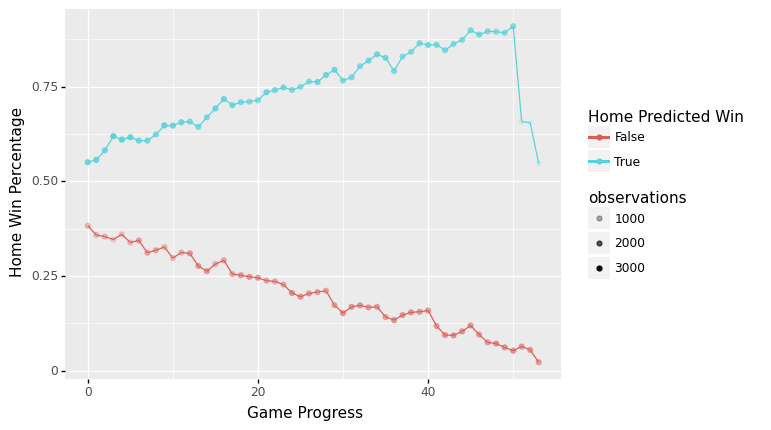

<ggplot: (117184257762)>

In [16]:
temp = test_data.groupby(['game_progress', 'predicted_win', 'is_overtime']).agg({'home_wins': 'mean', 'event_num': 'count'}).reset_index()
temp['predicted_win'] = temp['predicted_win'].astype('category')
temp = temp.rename(index = str, columns = {'event_num': 'observations'})

ggplot(aes(x = 'game_progress', y = 'home_wins', color = 'predicted_win'), data = temp.query('is_overtime == False')) +\
geom_line() + geom_point(aes(alpha = 'observations')) + xlab("Game Progress") + ylab("Home Win Percentage") + scale_color_discrete(name = "Home Predicted Win")

### One particular game

One of the best ways to see how a model is performing is to dive into anecdotes. In this case, we'll pick a single game, and see how our predictions evolved at each step in the game. Hopefully, any big changes in the predictions are associated with a big change in the game as well!

In this case, we'll look at the game between the Washington Nationals and the Miami Marlins on April 3, 2017. Below we plot all three predictions for each play in this game.


In [17]:
train_data

,game_id,season,date,visitor,home,night_game,game_site,inning,batting_team,outs,...,vis_own_score_100,vis_opp_score_100,hom_own_score_season,hom_opp_score_season,hom_own_score_100,hom_opp_score_100,game_progress,is_overtime,day_of_week,month
283248,ANA201504120,2015,2015-04-12,KCA,ANA,0,ANA01,1,0,0,...,4.09,3.69,2.800000,3.40000,4.70,3.65,0,0.0,6,4
283249,ANA201504120,2015,2015-04-12,KCA,ANA,0,ANA01,1,0,1,...,4.09,3.69,2.800000,3.40000,4.70,3.65,1,0.0,6,4
283250,ANA201504120,2015,2015-04-12,KCA,ANA,0,ANA01,1,0,2,...,4.09,3.69,2.800000,3.40000,4.70,3.65,2,0.0,6,4
283251,ANA201504120,2015,2015-04-12,KCA,ANA,0,ANA01,1,0,2,...,4.09,3.69,2.800000,3.40000,4.70,3.65,2,0.0,6,4
283252,ANA201504120,2015,2015-04-12,KCA,ANA,0,ANA01,1,1,0,...,4.09,3.69,2.800000,3.40000,4.70,3.65,3,0.0,6,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1458933,WAS201710010,2017,2017-10-01,PIT,WAS,0,WAS11,9,1,0,...,4.01,4.27,5.037267,4.10559,4.79,4.00,51,0.0,6,10
1458934,WAS201710010,2017,2017-10-01,PIT,WAS,0,WAS11,9,1,1,...,4.01,4.27,5.037267,4.10559,4.79,4.00,52,0.0,6,10
1458935,WAS201710010,2017,2017-10-01,PIT,WAS,0,WAS11,9,1,2,...,4.01,4.27,5.037267,4.10559,4.79,4.00,53,0.0,6,10
1458936,WAS201710010,2017,2017-10-01,PIT,WAS,0,WAS11,9,1,2,...,4.01,4.27,5.037267,4.10559,4.79,4.00,53,0.0,6,10


In [22]:
this_game = train_data[train_data['game_id'] == "WAS201704030"].copy()

mplotdat = pd.melt(this_game, id_vars = ['event_num'], value_vars =['home_win_prediction_final'])

In [23]:
this_game.head()

,game_id,season,date,visitor,home,night_game,game_site,inning,batting_team,outs,...,hom_own_score_season,hom_opp_score_season,hom_own_score_100,hom_opp_score_100,game_progress,is_overtime,day_of_week,month,home_win_prediction_start,home_win_prediction_final
1455721,WAS201704030,2017,2017-04-03,MIA,WAS,0,WAS11,1,0,0,...,0.0,0.0,4.76,4.0,0,0.0,0,4,0.613329,0.606681
1455722,WAS201704030,2017,2017-04-03,MIA,WAS,0,WAS11,1,0,1,...,0.0,0.0,4.76,4.0,1,0.0,0,4,0.613329,0.637457
1455723,WAS201704030,2017,2017-04-03,MIA,WAS,0,WAS11,1,0,2,...,0.0,0.0,4.76,4.0,2,0.0,0,4,0.613329,0.647452
1455724,WAS201704030,2017,2017-04-03,MIA,WAS,0,WAS11,1,1,0,...,0.0,0.0,4.76,4.0,3,0.0,0,4,0.613329,0.647487
1455725,WAS201704030,2017,2017-04-03,MIA,WAS,0,WAS11,1,1,0,...,0.0,0.0,4.76,4.0,3,0.0,0,4,0.613329,0.707443


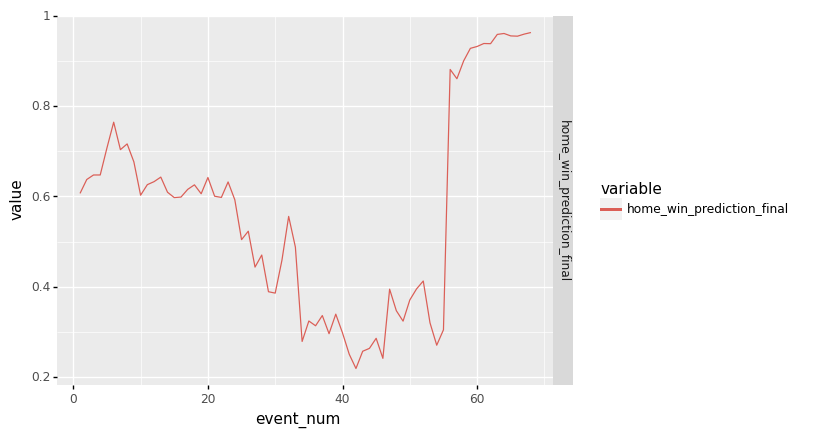

<ggplot: (117183548230)>

In [24]:
ggplot(aes(x = 'event_num', y = 'value', color = 'variable'), data = mplotdat) +\
geom_line() +\
facet_grid("variable~.", scales = 'free_y')

What do we see here? First, we see that the models start out predicting effectively a toss-up game. The expected score is about 4-4, and the home team has a win probability of just over 50%. This probability bounces around 50% until around event 30, where the Marlins (the away team) see a big jump in their expected score. What happened there?

Here is the play-by-play from that period. Notice that at Event 25 there's now a Miami runner on second base, with no outs. The model bumps up the away team prediction by ~0.7 runs. The next row, the runner advances to third but the Marlins get an out as well. That drops the expected score a bit, from 3.44 to 3.21.

In Event 27 we see the score is now 1 - 0 for the Marlins! The expected score jumps up, from 3.21 to 4. Notice the Marlins scored a run, but the prediction only increased by ~0.8 runs. Why? In part, because the model has been upping the prediction all inning - it knows there's some chance a runner on third scores, and was baking that in *before* the runner scores (incidentally, this is the reason I don't like RBI as a metric.)

Event 29 sees another run come in. We started the inning at an effective toss-up, with Washington having a 56% chance of winning. By the end of the half, though, Miami is up 2-0, and Washington only has a 33.3% chance of winning

In [25]:
this_game[(this_game['inning'] == 4) & (this_game['batting_team'] == 0)]

,game_id,season,date,visitor,home,night_game,game_site,inning,batting_team,outs,...,hom_own_score_season,hom_opp_score_season,hom_own_score_100,hom_opp_score_100,game_progress,is_overtime,day_of_week,month,home_win_prediction_start,home_win_prediction_final
1455744,WAS201704030,2017,2017-04-03,MIA,WAS,0,WAS11,4,0,0,...,0.0,0.0,4.76,4.0,18,0.0,0,4,0.613329,0.592508
1455745,WAS201704030,2017,2017-04-03,MIA,WAS,0,WAS11,4,0,0,...,0.0,0.0,4.76,4.0,18,0.0,0,4,0.613329,0.504240
1455746,WAS201704030,2017,2017-04-03,MIA,WAS,0,WAS11,4,0,1,...,0.0,0.0,4.76,4.0,19,0.0,0,4,0.613329,0.522977
1455747,WAS201704030,2017,2017-04-03,MIA,WAS,0,WAS11,4,0,1,...,0.0,0.0,4.76,4.0,19,0.0,0,4,0.613329,0.443460
1455748,WAS201704030,2017,2017-04-03,MIA,WAS,0,WAS11,4,0,2,...,0.0,0.0,4.76,4.0,20,0.0,0,4,0.613329,0.470127
1455749,WAS201704030,2017,2017-04-03,MIA,WAS,0,WAS11,4,0,2,...,0.0,0.0,4.76,4.0,20,0.0,0,4,0.613329,0.388937


There's a spike in the probability of Washington winning around event 32. What's happening there?

When we zoom in below, the Nationals have runners on 1st and 2nd, with no outs. That's pretty good, so their win probability jumps up to 47%. The next play is a strike-out, dropping the win probability to 40%. And the next play is a double play, ending the inning with the score still at 2-0 (the win probability now is 28%). 

This is another reason this metric may outperform traditional batting statistics. The strike-out and double play came at pivotal times, and should be penalized more than a normal out would be.

In [26]:
this_game[(this_game['event_num'].isin([30,31,32,33,34]))]

,game_id,season,date,visitor,home,night_game,game_site,inning,batting_team,outs,...,hom_own_score_season,hom_opp_score_season,hom_own_score_100,hom_opp_score_100,game_progress,is_overtime,day_of_week,month,home_win_prediction_start,home_win_prediction_final
1455750,WAS201704030,2017,2017-04-03,MIA,WAS,0,WAS11,4,1,0,...,0.0,0.0,4.76,4.0,21,0.0,0,4,0.613329,0.385812
1455751,WAS201704030,2017,2017-04-03,MIA,WAS,0,WAS11,4,1,0,...,0.0,0.0,4.76,4.0,21,0.0,0,4,0.613329,0.458594
1455752,WAS201704030,2017,2017-04-03,MIA,WAS,0,WAS11,4,1,0,...,0.0,0.0,4.76,4.0,21,0.0,0,4,0.613329,0.555729
1455753,WAS201704030,2017,2017-04-03,MIA,WAS,0,WAS11,4,1,1,...,0.0,0.0,4.76,4.0,22,0.0,0,4,0.613329,0.487671
1455754,WAS201704030,2017,2017-04-03,MIA,WAS,0,WAS11,5,0,0,...,0.0,0.0,4.76,4.0,24,0.0,0,4,0.613329,0.278801


One more: obviously, the Nationals actually win this game. Something huge happens around play 55. What's that?

At this point, the score is 2-1 in favor of the Marlins, and it's the 7th inning. Notice event 56, the score changes to 3-2, for the Nationals! That's a two-run home run, moving the probability of the Nationals winning from 33% up to 87%. This is a really big play, and the model gets that.

In [27]:
this_game[(this_game['event_num'].isin([53,54,55,56,57,58]))]

,game_id,season,date,visitor,home,night_game,game_site,inning,batting_team,outs,...,hom_own_score_season,hom_opp_score_season,hom_own_score_100,hom_opp_score_100,game_progress,is_overtime,day_of_week,month,home_win_prediction_start,home_win_prediction_final
1455773,WAS201704030,2017,2017-04-03,MIA,WAS,0,WAS11,7,1,1,...,0.0,0.0,4.76,4.0,40,0.0,0,4,0.613329,0.320090
1455774,WAS201704030,2017,2017-04-03,MIA,WAS,0,WAS11,7,1,2,...,0.0,0.0,4.76,4.0,41,0.0,0,4,0.613329,0.270484
1455775,WAS201704030,2017,2017-04-03,MIA,WAS,0,WAS11,7,1,2,...,0.0,0.0,4.76,4.0,41,0.0,0,4,0.613329,0.304539
1455776,WAS201704030,2017,2017-04-03,MIA,WAS,0,WAS11,7,1,2,...,0.0,0.0,4.76,4.0,41,0.0,0,4,0.613329,0.881167
1455777,WAS201704030,2017,2017-04-03,MIA,WAS,0,WAS11,8,0,0,...,0.0,0.0,4.76,4.0,42,0.0,0,4,0.613329,0.860639
1455778,WAS201704030,2017,2017-04-03,MIA,WAS,0,WAS11,8,0,1,...,0.0,0.0,4.76,4.0,43,0.0,0,4,0.613329,0.900099


### Pitcher performance

We can use the exact same process to see how pitchers performed in the game. If we look at their probability of winning the game, did it get better or worse while they were pitching?

In this game, the losing pitcher was Phelps on the Marlins side. He started pitching at event 46, and left the game at event 57. The Nationals had a 24% chance of winning when Phelps started pitching - by the time he left, that was up to 84%! That's absolutely a pitcher deserving a loss.

The winning pitcher was Stephen Strasburg. He started the game, so the Nats has a 56% chance of winning at that point. When he left, the Nats had a 40% chance of winning...wait, what? He made the situation worse?! Digging a bit deeper, that's exactly what happened. When Strasburg threw his last pitch, the Nats were down 2-1. They scored 2 runs in the bottom of the inning, but that was *after* Strasburg was done pitching. Traditional baseball stats call him the winning pitcher, but the picture is a lot more muddy!

Of course, it's not obvious that Strasburg's value should depend on how well his team bats, either...that's why we have the score predictions. When Strasburg started, we expected the Marlins to score 4.7 runs - when he left, that was down to 2.8 runs. That's a good game for a pitcher, even if they don't end up winning! That's probably a more useful metric for pitchers.

In [28]:
this_game[this_game['event_num'].isin([46, 57])]

,game_id,season,date,visitor,home,night_game,game_site,inning,batting_team,outs,...,hom_own_score_season,hom_opp_score_season,hom_own_score_100,hom_opp_score_100,game_progress,is_overtime,day_of_week,month,home_win_prediction_start,home_win_prediction_final
1455766,WAS201704030,2017,2017-04-03,MIA,WAS,0,WAS11,6,1,1,...,0.0,0.0,4.76,4.0,34,0.0,0,4,0.613329,0.241345
1455777,WAS201704030,2017,2017-04-03,MIA,WAS,0,WAS11,8,0,0,...,0.0,0.0,4.76,4.0,42,0.0,0,4,0.613329,0.860639


In [29]:
this_game[this_game['event_num'].isin([1, 52])]

,game_id,season,date,visitor,home,night_game,game_site,inning,batting_team,outs,...,hom_own_score_season,hom_opp_score_season,hom_own_score_100,hom_opp_score_100,game_progress,is_overtime,day_of_week,month,home_win_prediction_start,home_win_prediction_final
1455721,WAS201704030,2017,2017-04-03,MIA,WAS,0,WAS11,1,0,0,...,0.0,0.0,4.76,4.0,0,0.0,0,4,0.613329,0.606681
1455772,WAS201704030,2017,2017-04-03,MIA,WAS,0,WAS11,7,1,0,...,0.0,0.0,4.76,4.0,39,0.0,0,4,0.613329,0.412657


In [30]:
test_data.to_sql(name='test_predictions', con=engine, if_exists='replace')

27